# 49 Facial Expression Classification
# Estudiantes: 
* Luz Clara Mora Salazar 
* Julio César Castro
# Analisis del problema

El desafío consiste en crear un modelo de aprendizaje profundo para distinguir tres emociones (Descontento, Interés y Neutral) a partir de imágenes de rostros. Esto implica extraer características faciales y clasificar expresiones, lo que es esencial para aplicaciones en el análisis del comportamiento humano.

# Librerías

In [1]:
import itertools
from PIL import Image
import os
import random

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers


# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
physical_devices = tf.config.list_physical_devices('GPU')

if physical_devices:
    try:
        tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')
        print("GPU is set for TensorFlow.")
    except RuntimeError as e:
        print("Error setting GPU: ", e)
else:
    print("No GPU found. TensorFlow will use the CPU")

GPU is set for TensorFlow.


# Carga de datos
Dirigasé al siguiente enlace donde encontrará el dataset en formato .zip descarguelo y agreguelo a la ruta del proyecto
https://drive.google.com/file/d/1YXFYPtyk0scy6cj1aJ-b4CcBbXVmyJQp/view?usp=sharing

In [21]:
import zipfile

# Ruta al archivo zip
zip_path = "FER_Custom_Dataset.zip"
# Ruta al directorio donde quieres descomprimir el archivo
extract_path = "FER_Custom_Dataset"
# Descomprimir el archivo
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Archivo descomprimido en: {extract_path}")

Archivo descomprimido en: FER_Custom_Dataset


# Preparación de los datos 

In [22]:
def preprocess_and_save_image(src, dst, size=(100, 100)):
    img = Image.open(src)
    img = img.resize(size)
    # Convertir la imagen a modo RGB
    img = img.convert('RGB')
    img.save(dst)


def split_dataset(input_folder, output_folder, train_ratio=0.6, test_ratio=0.2, val_ratio=0.2, seed=None):

    if seed is not None:
        random.seed(seed)

    # Crear carpetas de salida
    train_dir = os.path.join(output_folder, 'train')
    test_dir = os.path.join(output_folder, 'test')
    val_dir = os.path.join(output_folder, 'val')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    # Iterar sobre subcarpetas
    for class_folder in os.listdir(input_folder):
        class_path = os.path.join(input_folder, class_folder)
        if os.path.isdir(class_path):
            class_files = os.listdir(class_path)
            random.shuffle(class_files)

            # Calcular el número de ejemplos para cada división.
            num_samples = len(class_files)
            num_train = int(train_ratio * num_samples)
            num_test = int(test_ratio * num_samples)
            num_val = num_samples - num_train - num_test

            # Asignar archivos a cada división
            train_files = class_files[:num_train]
            test_files = class_files[num_train:num_train + num_test]
            val_files = class_files[-num_val:]

            for files, folder in zip([train_files, test_files, val_files], [train_dir, test_dir, val_dir]):
                for filename in files:
                    src = os.path.join(class_path, filename)
                    dst = os.path.join(folder, class_folder, filename)
                    os.makedirs(os.path.dirname(dst), exist_ok=True)
                    preprocess_and_save_image(src, dst)


# Ejemplo:
input_folder = "./FER_Custom_Dataset/FER_Custom_Dataset"  # Ruta a la carpeta que contiene subcarpetas para cada clase
output_folder = "./examenll/emociones_procesadas"  # Ruta a la carpeta de salida donde se guardarán los conjuntos de train test  val
split_dataset(input_folder, output_folder)


In [2]:
# Define data augmentation and normalization parameters for training data
train_datagen = ImageDataGenerator(
  rescale=1/255.0,
  rotation_range=7,
  horizontal_flip=True,
  validation_split=0.2
)
# Create a data generator for training data with one-hot encoded labels
train_generator = train_datagen.flow_from_directory(
    './examenll/emociones_procesadas/train',
    target_size=(64,64),
    batch_size=16,
    subset="training")  # Shuffle the data

# Define data augmentation and normalization parameters for validation data
val_datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=7,
    horizontal_flip=True,
    validation_split=0.2
)

# Create a data generator for validation data with one-hot encoded labels
val_generator = val_datagen.flow_from_directory(
    './examenll/emociones_procesadas/val',
    target_size=(64, 64),
    batch_size=16,
    subset='validation',
    shuffle=False)  # No need to shuffle validation data
ts_gen = ImageDataGenerator(
     rescale=1/255.0,
    rotation_range=7,
    horizontal_flip=True,
    validation_split=0.2
)
test_gen = ts_gen.flow_from_directory(
    './examenll/emociones_procesadas/test',
    target_size=(64, 64),
    batch_size=16,
    shuffle=False)  # No need to shuffle validation data

Found 21033 images belonging to 3 classes.
Found 1752 images belonging to 3 classes.
Found 8763 images belonging to 3 classes.


# Entendimiento de los datos o visualización

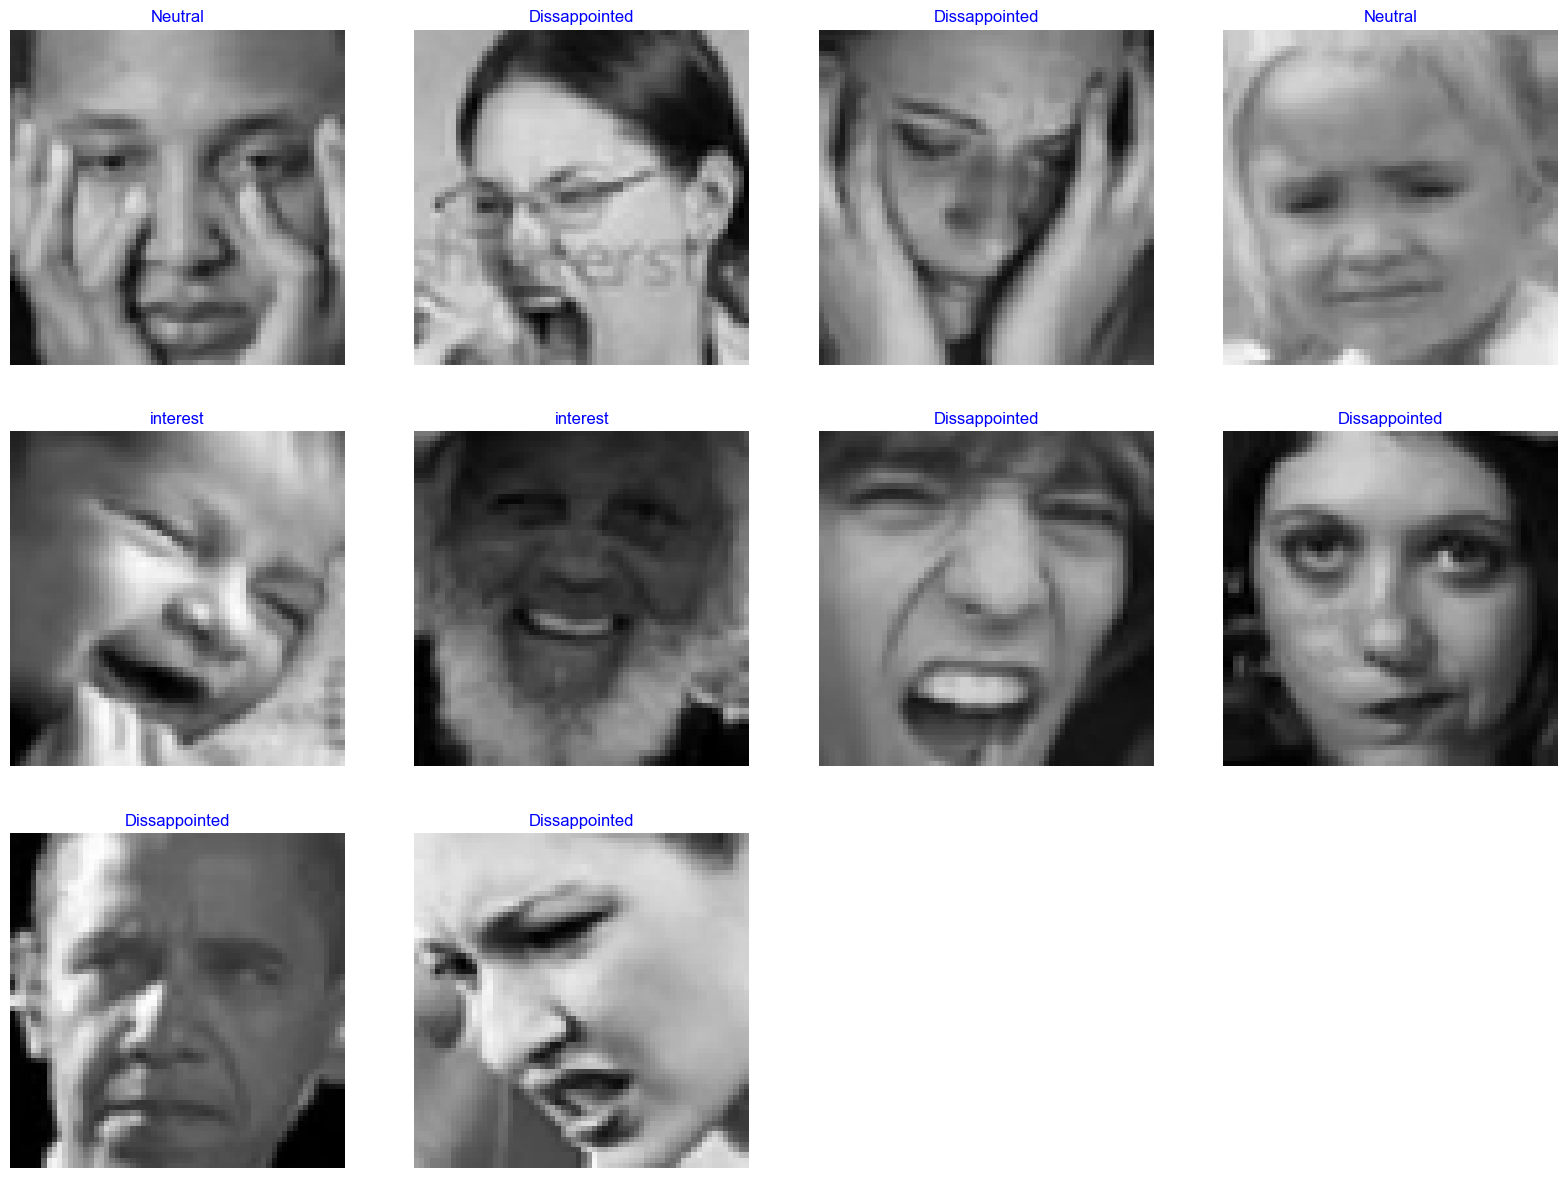

In [3]:
classes = ['Dissappointed', 'interest', 'Neutral']      
images, labels = next(train_generator)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(10):
    plt.subplot(4, 4, i + 1)
    image = images[i]     # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# Modelo de Deep Learning

In [8]:
num_classes = 3
num_detectors=32

model = Sequential(
    [Conv2D(num_detectors, (3,3), activation='relu', padding = 'same', input_shape = (64, 64, 3)),
    Conv2D(num_detectors, (3,3), activation='relu', padding = 'same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),
    
    Conv2D(2*num_detectors, (3,3), activation='relu', padding = 'same'),
    BatchNormalization(),
    Conv2D(2*num_detectors, (3,3), activation='relu', padding = 'same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),
    
    Conv2D(2*2*num_detectors, (3,3), activation='relu', padding = 'same'),
    BatchNormalization(),
    Conv2D(2*2*num_detectors, (3,3), activation='relu', padding = 'same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),
    
    Conv2D(2*2*2*num_detectors, (3,3), activation='relu', padding = 'same'),
    BatchNormalization(),
    Conv2D(2*2*2*num_detectors, (3,3), activation='relu', padding = 'same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),
    
    Flatten(),
    
    Dense(2 * num_detectors,kernel_regularizer= regularizers.l2(0.01), activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(2 * num_detectors,kernel_regularizer= regularizers.l2(0.01), activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(num_classes, activation='softmax')]
)



In [9]:
optimizers=Adamax(learning_rate=0.001,beta_1=0.9,beta_2=0.99,decay=0.001/32)
EarlyStop=EarlyStopping(patience=10,restore_best_weights=True,monitor='val_loss')
Reduce_LR=ReduceLROnPlateau(monitor='loss',verbose=2,factor=0.5,min_lr=0.00001)
callback=[EarlyStop , Reduce_LR]

In [10]:
model.compile(optimizer=optimizers,loss='categorical_crossentropy', metrics=["accuracy"])
history=model.fit(train_generator,validation_data=val_generator,epochs=20, callbacks=callback, verbose=2)

Epoch 1/20
1315/1315 - 171s - loss: 2.2717 - accuracy: 0.3741 - val_loss: 1.5341 - val_accuracy: 0.3373 - lr: 0.0010 - 171s/epoch - 130ms/step
Epoch 2/20
1315/1315 - 43s - loss: 1.3709 - accuracy: 0.3992 - val_loss: 1.2817 - val_accuracy: 0.4235 - lr: 0.0010 - 43s/epoch - 33ms/step
Epoch 3/20
1315/1315 - 44s - loss: 1.1763 - accuracy: 0.4523 - val_loss: 1.0794 - val_accuracy: 0.5200 - lr: 0.0010 - 44s/epoch - 34ms/step
Epoch 4/20
1315/1315 - 46s - loss: 1.0410 - accuracy: 0.5265 - val_loss: 0.9864 - val_accuracy: 0.5251 - lr: 0.0010 - 46s/epoch - 35ms/step
Epoch 5/20
1315/1315 - 43s - loss: 0.9544 - accuracy: 0.5644 - val_loss: 0.8867 - val_accuracy: 0.5919 - lr: 0.0010 - 43s/epoch - 33ms/step
Epoch 6/20
1315/1315 - 45s - loss: 0.8925 - accuracy: 0.6025 - val_loss: 0.9016 - val_accuracy: 0.6005 - lr: 0.0010 - 45s/epoch - 34ms/step
Epoch 7/20
1315/1315 - 46s - loss: 0.8641 - accuracy: 0.6247 - val_loss: 0.8485 - val_accuracy: 0.6187 - lr: 0.0010 - 46s/epoch - 35ms/step
Epoch 8/20
1315/1

# Evaluación del modelo

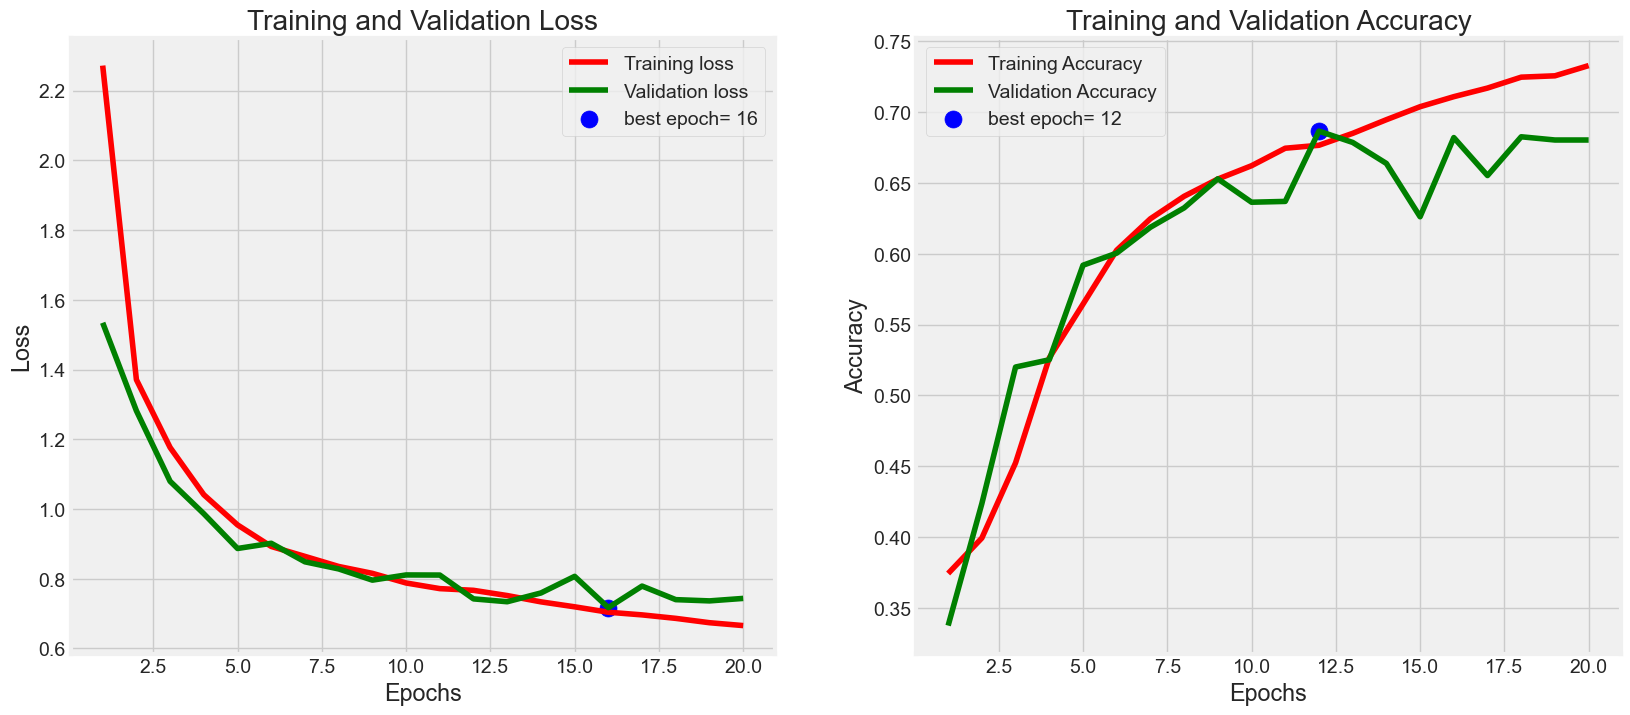

In [11]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show()

In [12]:
#  tamaño del set de entrenamiento y validación
train_size = len(train_generator)
val_size = len(val_generator)

# Calcula los batch sizes y steps para cada generador
train_batch_size = max(sorted([train_size // n for n in range(1, train_size + 1) if train_size % n == 0 and train_size / n <= 80]))
train_steps = train_size // train_batch_size

val_batch_size = max(sorted([val_size // n for n in range(1, val_size + 1) if val_size % n == 0 and val_size / n <= 80]))
val_steps = val_size // val_batch_size

# Evalúa el modelo en el set de entrenamiento
train_score = model.evaluate(train_generator, steps=train_steps, verbose=1)

# Evalúa el modelo en el set de validación
valid_score = model.evaluate(val_generator, steps=val_steps, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])

2/2 [==============================] - 0s 34ms/step - loss: 1.2371 - accuracy: 0.2812
Train Loss:  0.5657187700271606
Train Accuracy:  0.786596953868866
--------------------
Validation Loss:  1.2370691299438477
Validation Accuracy:  0.28125


# Resultados y Predicciones

In [13]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

548/548 [==============================] - 70s 127ms/step


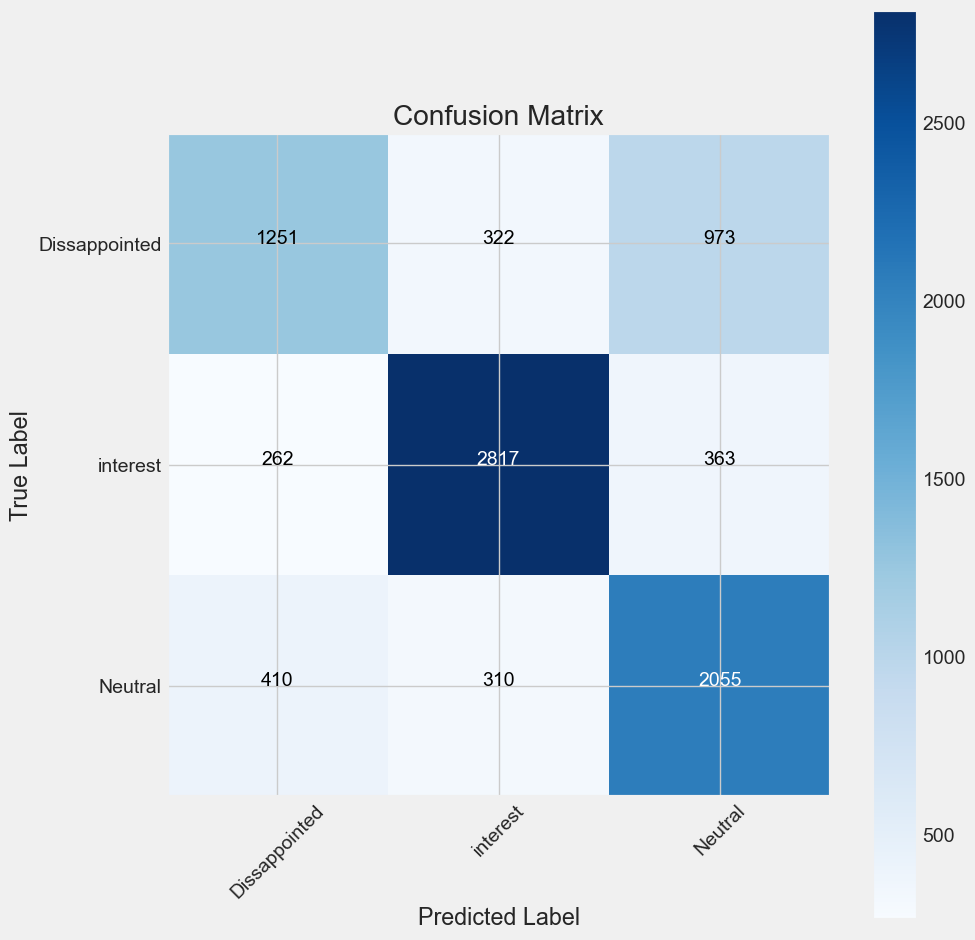

In [15]:
classes = ['Dissappointed', 'interest', 'Neutral']  

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


In [16]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

               precision    recall  f1-score   support

Dissappointed       0.65      0.49      0.56      2546
     interest       0.82      0.82      0.82      3442
      Neutral       0.61      0.74      0.67      2775

     accuracy                           0.70      8763
    macro avg       0.69      0.68      0.68      8763
 weighted avg       0.70      0.70      0.69      8763



Guardar el modelo

In [17]:
model.save("emotions_model.h5")

In [18]:
loaded_model = tf.keras.models.load_model('./emotions_model.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [25]:
image_path = './examenll/emociones_procesadas/test/Disappointed/51.jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((64, 64))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels =  ['Dissappointed', 'interest', 'Neutral']   
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 0s 24ms/step
Dissappointed


# Conclusiones
El modelo aunque muestra un rendimiento aceptable en el conjunto de entrenamiento, con una precisión del 78.66%, su precisión en el conjunto de validación es significativamente menor, solo del 28.12%, lo que indica un notable sobreajuste.

El modelo no logró mejorar su capacidad de generalización a nuevos datos, a pesar de haber utilizado regularizadores L2 en capas densas, normalización por lotes (Batch Normalization) y regularización mediante salida. Además, se utilizaron métodos para ajustar hiperparámetros, como detener temprano (EarlyStopping) y reducir la tasa de aprendizaje (ReduceLROnPlateau). Sin embargo, el bajo rendimiento en las métricas de clasificación de prueba y la validación indica que el modelo requiere ajustes adicionales o una estrategia diferente para mejorar su precisión y capacidad de generalización.